The goal of this notebook is to produce an annual estimate of wildfire smoke exposure in Madison, WI, to better understand its effects on the city. We will focus on estimating the level of smoke during each year's wildfire season based on the available data while acknowledging the limitations of the data. Smoke during wildfires depends on many factors, such as fire intensity, wind speed and direction, temperature, humidity, terrain, vegetation type, and proximity to populated areas. However, the wildfire data we have is very limited, so we will create an estimate of the smoke with just the available data.

In [489]:
import pandas as pd

from scipy.stats import pearsonr

import seaborn as sns

import matplotlib.pyplot as plt

Loading the previously generated madison subset of wildfire data.

In [490]:
wildfire_df = pd.read_csv('intermediary_files/madison_wildfire_1964_2024.csv')

As mentioned earlier smoke depends on several factors. But most importantly

This function computes an estimated smoke value for a wildfire based on several factors, including fire type, fire size, area, wind, and proximity. 

- **Area**: Primarily smoke is directly proportional to the amount of fuel burned, which in turn is proportional to the area burned. Since we have `GIS_Acres` available, this can be useful in eastimating the smoke.

- **Distance**: Smoke is inversely proportional to distance because, as you move further away from a smoke source, the concentration of smoke particles in the air decreases due to diffusion and dispersion. This means that the visibility and intensity of smoke diminish with increasing distance from the origin of the smoke. we have the calculated `shortest_dist` columns that we can use for the estimation.

We do not have any direct fields such as wind speed, duration etc that can be used in estimation. But we can use the available fields to indirectly estimate some of these factors which can be used to estimate the smoke.

- **Fire Intensity**: Determined based on the `Assigned_Fire_Type`. Each fire type is categorized based on its potential threat, with "Wildfire" and "Prescribed Fire" assigned the highest intensity factor of 5, because of their significant risk. The "Likely Wildfire" and "Unknown - Wildfire" types are assigned lower values (4 and 3, respectively) because they are uncertain but still considerable danger, while others are given a small value of 0.5, considering their minimal impact. 

- **Duration**: We can determine the duration based on `Shape_area`, with larger fires expected to last longer. Larger areas, indicated by thresholds (greater than 1,000,000 and 500,000 square units), are associated with higher duration factors (2 and 1.5, respectively), suggesting they may sustain fires longer, while smaller areas are assigned lower values, indicating a shorter duration of fire potential.

- **Wind**: The ratio of `Shape_Length` to `Shape_Area` helps assess how elongated a fire's shape is compared to its overall size, which can indicate the wind behaviour. A higher ratio means the fire shape is longer and thinner, which allows smoke to disperse more easily and travel further, potentially resulting in higher smoke concentrations downwind. In contrast, a lower ratio indicates a more compact shape, where the smoke is likely to remain closer to the ground and spread less, leading to lower overall smoke concentrations and reduced visibility.

- **Circleness**: The `Circleness_Scale` field indicates how cirular the fire shape is and can be used determine the smoke levels. A more circular shape tends to contain the smoke more effectively, leading to higher concentrations of smoke in the immediate area, as it limits the surface area exposed to wind. Conversely, a less circular shape allows for greater smoke dispersion leading to lower concentrations in the area.

Combining all the above, we can determine smoke as below.

$$Smoke = \frac{Area \times Fire Intensity \times Duration \times Wind \times Circleness}{distance}$$

This smoke estimate takes into account multiple factors that affect how much smoke is produced and how it spreads. By considering the area of the fire, the intensity of the flames, how long the fire lasts, the impact of wind, and the shape of the fire, the formula provides a comprehensive way to estimate smoke levels just using the available data. 

In [491]:
def calculate_smoke_estimate(row):
    gis_acres = row['GIS_Acres']
    assigned_fire_type = row['Assigned_Fire_Type']
    shape_area = row['Shape_Area']
    shape_length = row['Shape_Length']
    shortest_dist = row['shortest_dist']
    circleness = row['Circleness_Scale']

    # Fire Intensity 
    if assigned_fire_type == "Wildfire":
        fire_intensity_factor = 5
    elif assigned_fire_type == "Likely Wildfire":
        fire_intensity_factor = 4
    elif assigned_fire_type == "Prescribed Fire":
        fire_intensity_factor = 5
    elif assigned_fire_type == "Unknown - Wildfire":
        fire_intensity_factor = 3
    else:
        fire_intensity_factor = 0.5

    # Duration 
    if shape_area > 1000000:
        duration_factor = 2
    elif shape_area > 500000:
        duration_factor = 1.5
    elif shape_area > 100000:
        duration_factor = 1
    else:
        duration_factor = 0.5

    # Wind Factor
    wind_factor = 2 if shape_length / shape_area > 0.01 else 0.5

    # Calculate Smoke Estimate
    smoke_estimate = (gis_acres * fire_intensity_factor * duration_factor * wind_factor * circleness ) / (shortest_dist)

    return smoke_estimate

We will have to calculate the smoke estimate for every fire in out dataset. We will then sum the smoke value to get total smoke for teh given year. Since the scope of our analysis is limited to days between 1st May and 31st oct, to obtain yearly average, it makes sense to divide the total smoke for the year by 184 days.

In [492]:
wildfire_df['Smoke_Estimate'] = wildfire_df.apply(calculate_smoke_estimate, axis=1)

# Extract the year from Fire_Year and group by year to sum the smoke impact
smoke_by_year = wildfire_df.groupby('Fire_Year')['Smoke_Estimate'].sum().reset_index()

# Calculate annual average by dividing the annual sum by 184 (number of days betweem May to Oct)
smoke_by_year['Smoke_Estimate'] = smoke_by_year['Smoke_Estimate']/184

Now let us compare the annual smoke estimate to the annual AQI to validate our estimation accuracy. This comparison is important because it helps us see if our estimate truly shows how fire affects air quality through smoke. The AQI gives a clear measure of air pollution levels, including smoke particles. By checking our estimate against the AQI, we can confirm if estimation is close enough to the actual smoke levels. So will load the required Annual AQI data file.

In [493]:
aqi_df = pd.read_csv("intermediary_files/yearly_aqi_1964_2024.csv")

I chose to use the Pearson correlation coefficient to compare my smoke estimates with the AQI because it provides a clear statistical measure of the relationship between the two variables. By calculating the correlation, I can determine how strongly my smoke estimates align with the AQI values, which is essential for validating the defined smoke formula. A high correlation indicates that my smoke estimates effectively reflect changes in air quality due to wildfires.

In [494]:
# Merge smoke_df and aqi_df on the year column
merged_df = pd.merge(smoke_by_year, aqi_df, left_on='Fire_Year', right_on='year', how='inner')

pearson_corr = pearsonr(merged_df['Smoke_Estimate'], merged_df['aqi'])
correlation = pearson_corr[0]

print("Correlation between smoke and AQI:", correlation)


Correlation between smoke and AQI: 0.4489186560871011


A Pearson correlation coefficient of 0.45 between smoke and AQI indicates that there is a moderate positive correlation between the two variables. This moderate correlation which makes sense because there are other factors influencing the smoke than the ones that were available for the calculation. Similarly there are other pollutants and factors that affect the AQI besides the smoke from wildfire. 

Let us take a look at correlation plot to understand the distribution.


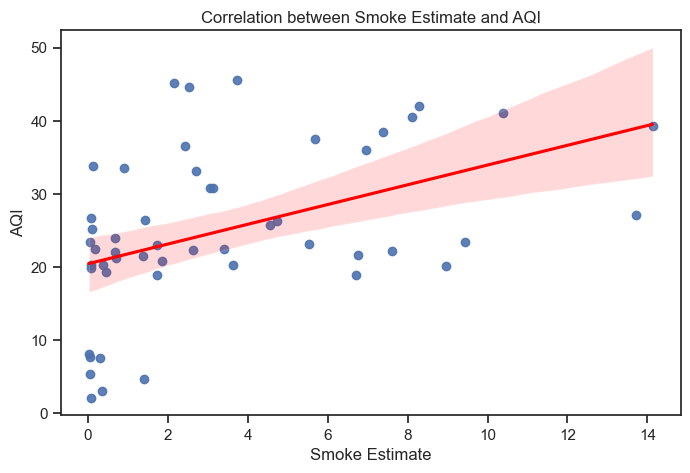

In [495]:
sns.set_theme(style="ticks")
# Create scatter plot with regression line
plt.figure(figsize=(8, 5))
sns.regplot(x='Smoke_Estimate', y='aqi', data=merged_df, scatter_kws={'alpha': 0.9}, line_kws={'color': 'red'})

# Add plot labels and title
plt.title('Correlation between Smoke Estimate and AQI')
plt.xlabel('Smoke Estimate')
plt.ylabel('AQI')

# Display the plot
plt.show()

The graph shows moderate correlation between AQI and smoke estimate with few outliers as seen in the left bottom corner of the graph. This is possible in a way that even with slightest increase in the smoke after a specified range, the AQI value increases largely. Moreover there could be additional pollutants and smoke from other causes that might be causing change in AQI.

we will now calculate a p value to see if this moderate correlation exists in true population.

In [496]:
p_value = pearson_corr[1]
print("P-value of the correlation test:", p_value)

P-value of the correlation test: 0.0009524095656508743


A p-value of 0.0009 from a correlation test indicates a statistically significant relationship between the two variables, calculated smoke and AQI. I think it is safe to assume at this point that, we have made a fair estimation of smoke which can be used for further analysis.

In [497]:
# Save fire year and smoke by year into a CSV file
smoke_by_year.to_csv('intermediary_files/madison_yearly_smoke_estimate_1964_2024.csv', index=False)

We will save this smoke estimation data into csv to be able to use later for predictive modeling.